In [1]:
library(gstat)
library(sp)
library(spacetime)
library(raster)
library(rgdal)
library(rgeos)



rgdal: version: 1.3-9, (SVN revision 794)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.0, released 2018/12/14
 Path to GDAL shared files: /home/satbigvm/anaconda3/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
 Path to PROJ.4 shared files: /home/satbigvm/anaconda3/share/proj
 Linking to sp version: 1.3-1 
rgeos version: 0.3-28, (SVN revision 572)
 GEOS runtime version: 3.7.1-CAPI-1.11.1 0 
 Linking to sp version: 1.3-1 
 Polygon checking: TRUE 



In [2]:
load(file="final.RData")
# var

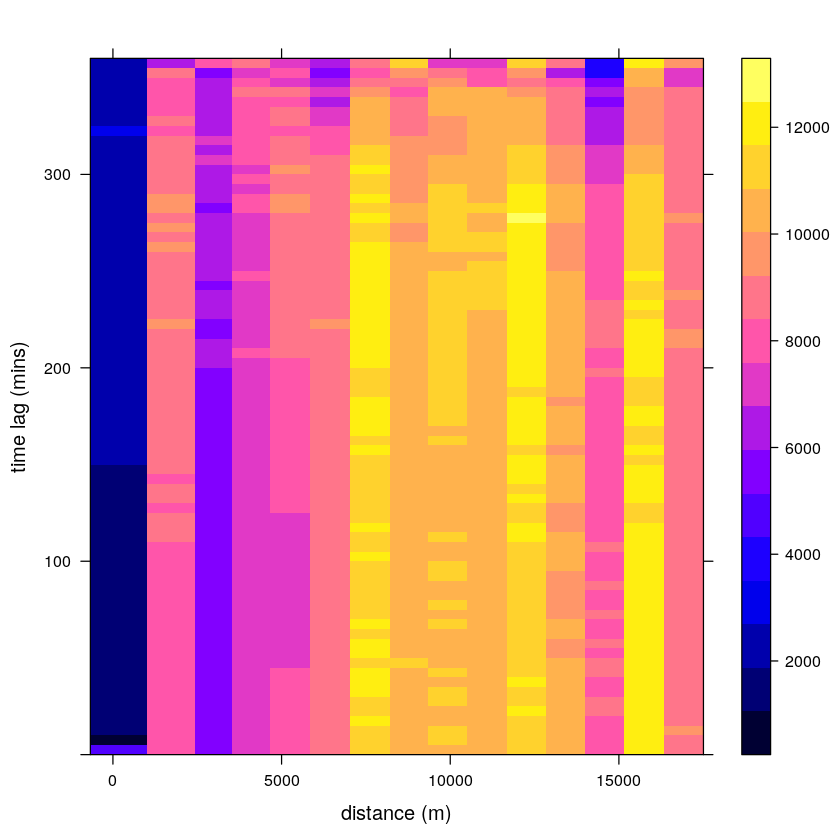

In [3]:
plot(var,map=T)

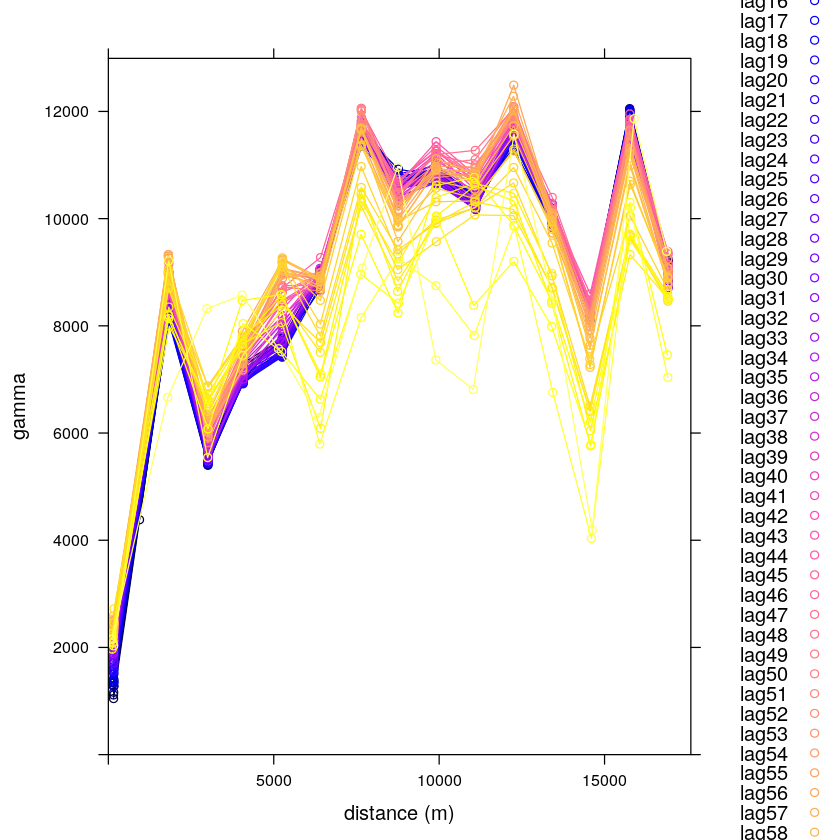

In [4]:
plot(var,map=F)

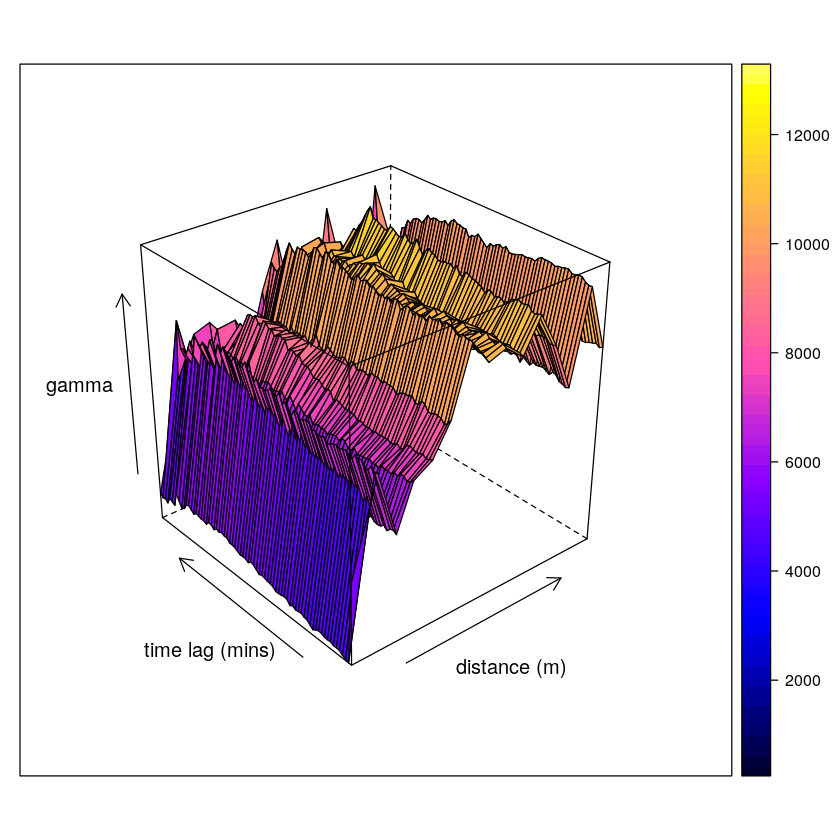

In [5]:
plot(var,wireframe=T)

[1] 2138607

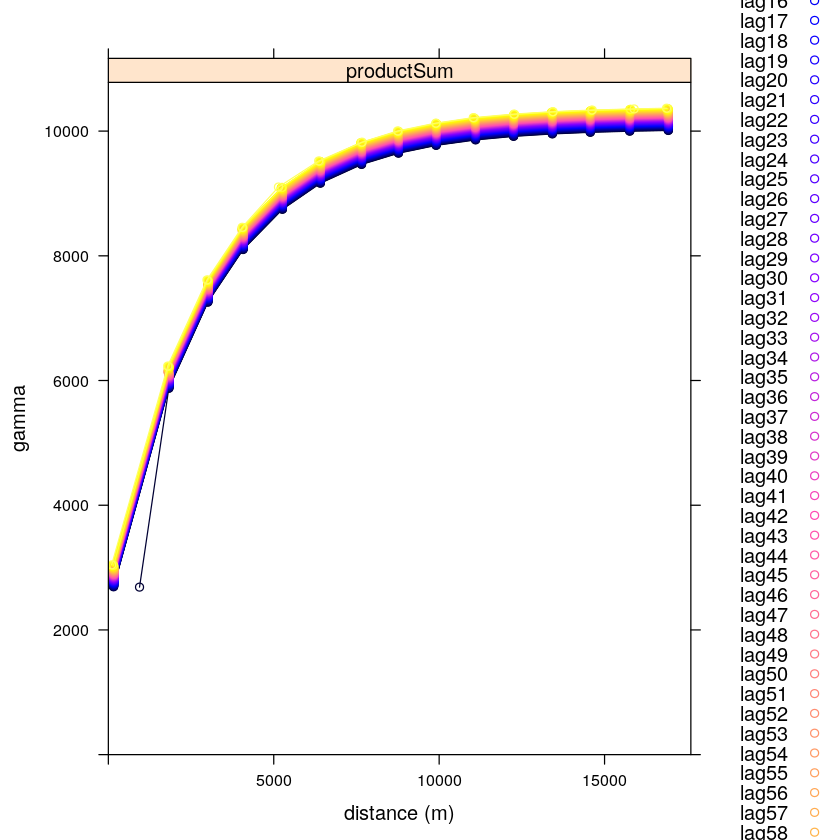

In [6]:
# PRODUCT SUM MODEL
prodSumModel <- vgmST("productSum",space = vgm(7000, "Exp", 6000, 0.5),time = vgm(10000, "Exp",150, 0.5),k = 50) 
prodSumModel_Vgm <- fit.StVariogram(var, prodSumModel,method = "L-BFGS-B",fit.time=TRUE)
attr(prodSumModel_Vgm, "MSE")
plot(var,prodSumModel_Vgm,map=F) 

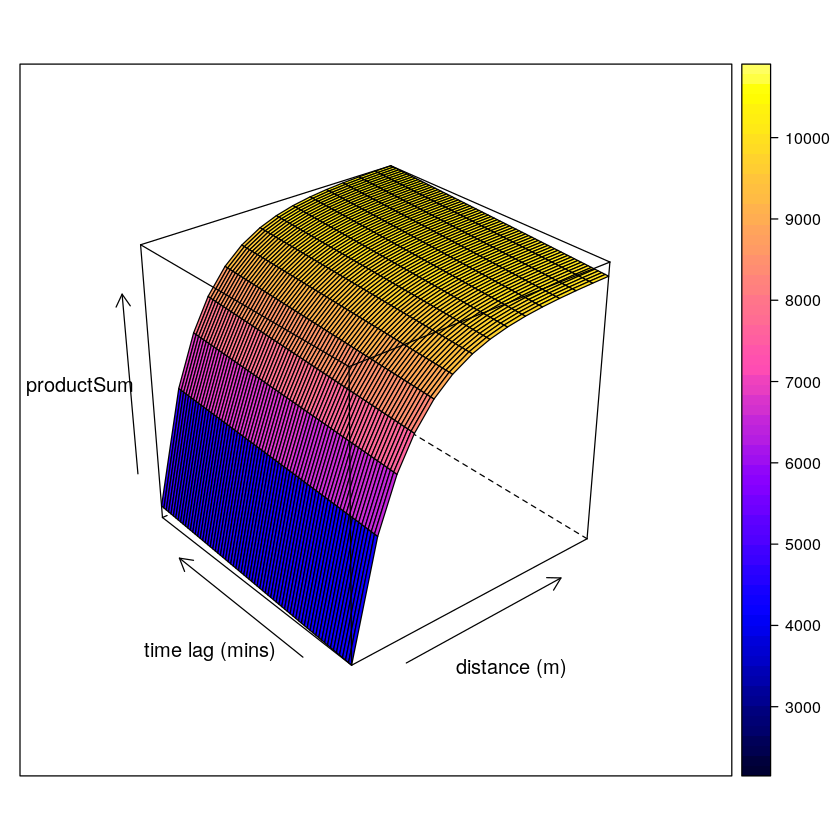

In [7]:
plot(var,prodSumModel_Vgm,wireframe=T)

In [8]:
test_data <- na.omit(test_data)
test_data <- test_data[order(test_data$Time),]
test_data_store <- test_data


In [9]:
#Create a SpatialPointsDataFrame
coordinates(test_data)=~long+lat
projection(test_data)=CRS("+init=epsg:4326")
#Transform into Mercator Projection
test_vehicles.UTM <- spTransform(test_data,CRS("+init=epsg:3395"))

In [10]:
# Dataframes for STIDF
test_vehiclesSP <- SpatialPoints(test_vehicles.UTM@coords,CRS("+init=epsg:3395"))
test_vehiclesTM <- as.POSIXct(test_vehicles.UTM$gentime,tz="CET")
tm.grid <- seq(as.POSIXct('2019-02-16 08:30:00 CET'),as.POSIXct('2019-02-16 13:40:00 CET'),length.out=1348)
# # print(head(tm.grid))
# # print(head(unique(vehiclesTM)))
# # tm.grid <- unique(vehiclesTM)
# # Merge
# grid.ST <- STF(test_vehiclesSP,tm.grid) 
# print(head(grid.ST))


In [11]:
grid.ST<- STI(test_vehiclesSP,test_vehiclesTM)

In [12]:
pred <- krigeST(Cars~1, data=timeDF, modelList=prodSumModel_Vgm, newdata=grid.ST)

In [13]:
predictions <- slot(pred,'data')
test_data_store$krigging_pred <- predictions

In [14]:
print(head(test_data_store))

        X FID     Time Car X2.w X3.w minibus bus light.commercial.vehicle
137   136   2 08:05:00 159   46   43       1  10                        1
271   270   4 08:05:00  65   50   31       0   4                        0
641   640  10 08:05:00  90   30   45       0   2                        3
917   916  14 08:05:00  23   38   27       1   8                        0
1441 1440  23 08:05:00 165  150   38       2   9                        2
1493 1492  24 08:05:00 264  134   19       1  12                        2
     heavy.commercial.vehicles Car...Jeep..Commercial.Yellow.plate. Others
137                          0                                    1      2
271                          0                                    0     20
641                          4                                    4      2
917                          0                                    0     18
1441                         6                                    0     37
1493                         3  

In [15]:
# 159,65,90,23,165,264,80,48,94,158
# 218,69,101,5,173,241,67,43,111,219

In [16]:
final_vals <- test_data_store[,c(4,23)]
names(final_vals)<- c("Actual", "Predicted")
print(final_vals)

     Actual  var1.pred
137     159 218.880312
271      65  69.208824
641      90 100.833273
917      23   4.724503
1441    165 172.880945
1493    264 241.645229
1817     80  67.669186
2481     48  42.947724
3625     94 110.997707
138     158 219.264360
204      52  67.995984
272      92  59.253159
486      58  55.588070
555     189 138.199024
578      91 147.141958
713     174 111.980132
1043     49  83.619254
2094     69  63.899352
2163     36  38.181357
2482     71  35.147033
2964    149 154.816387
3224    288 228.727683
3293    225 296.519239
3626     82  93.400871
139     171 212.608620
205      62  69.687423
415      16  23.603413
556     209 115.099383
783      22 -15.465079
986      97  95.901275
1371     95  95.940417
2290     49  38.057605
2483     36  22.930335
2758    143 185.244410
2965    142 142.280403
3034     66  58.561518
3507     68  78.940286
3627    138  99.693526
3790    134 116.153412
3962     36   2.721020
4095    148 127.478244
4151     34  15.303862
4211     63

In [17]:
final_vals$difsq <- (final_vals$Actual - final_vals$Predicted)^2
final_vals$dif <- (final_vals$Actual - final_vals$Predicted)
final_vals$absdif <- abs(final_vals$Actual - final_vals$Predicted)
final_vals$reldif <- abs((final_vals$Actual - final_vals$Predicted)/final_vals$Actual)
n <- nrow(final_vals)


In [18]:
print(head(final_vals))

     Actual  var1.pred  var1.pred  var1.pred var1.pred  var1.pred
137     159 218.880312 3585.65172 -59.880312 59.880312 0.37660573
271      65  69.208824   17.71420  -4.208824  4.208824 0.06475114
641      90 100.833273  117.35980 -10.833273 10.833273 0.12036970
917      23   4.724503  333.99381  18.275497 18.275497 0.79458685
1441    165 172.880945   62.10929  -7.880945  7.880945 0.04776330
1493    264 241.645229  499.73579  22.354771 22.354771 0.08467716


In [19]:
rss <- sum(final_vals$difsq)
# rss
mse <- rss/n
print('MSE')
mse

[1] "MSE"


[1] 755.2078

In [20]:
rmse <- sqrt(mse)
rmse
print('RMSE')

[1] 27.48104

[1] "RMSE"


In [21]:
mae <- sum(final_vals$absdif)/n
print('MAE')
mae

[1] "MAE"


[1] 18.94512

In [22]:
mape <- sum(final_vals$reldif)/n
print('MAPE')
mape

[1] "MAPE"


[1] 0.2483205

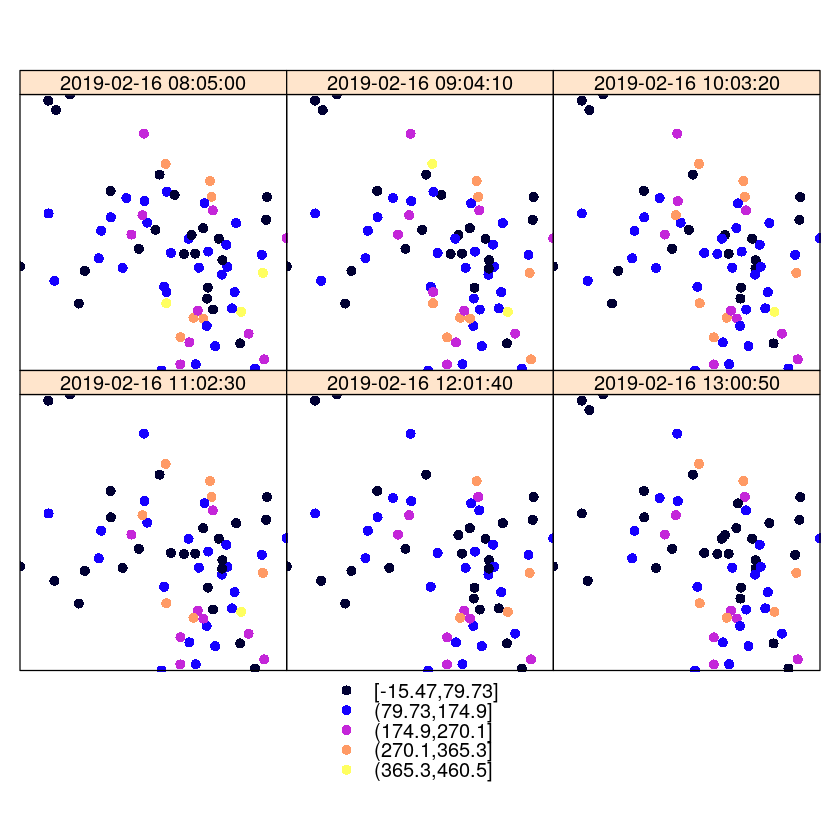

In [23]:
stplot(pred)